In [108]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pandas as pd

In [109]:
# Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length):
        self.data = pd.read_csv(file_path)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = 1 if self.data.iloc[idx]['binary_labels'] == 1 else 0

        inputs = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding=True)
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        hatespeech_dataset = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.float32)
        }

        return hatespeech_dataset

In [110]:
# Collate function
def my_collate_fn(batch):
    # Assuming each sample is a dictionary with 'input_ids', 'attention_mask', and 'label' keys
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.float)

    # Pad sequences to the length of the longest sequence in the batch
    padded_input_ids = pad_sequence(input_ids, batch_first=True)
    padded_attention_masks = pad_sequence(attention_masks, batch_first=True)

    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_masks,
        'label': labels
    }

In [111]:
# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Binary classification, so num_labels=1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:
# Dataset and dataloader
file_path = "/content/sample_data/data_train_preprocessed.csv"
max_length = 1582 # max input length
batch_size = 16

dataset = HateSpeechDataset(file_path, tokenizer, max_length)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=my_collate_fn, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=my_collate_fn, shuffle=False)

In [113]:
# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

In [118]:
# nums = 0
# print(len(train_loader.dataset))

# for batch in train_loader:
#     input = batch["input_ids"].to(device)
#     if len(input.size()) != 2:
#         print(nums)
#         print(input)
#         assert False
#     else:
#         print("processed", nums)
#         print(input.size(), input.max(), input.min())
#     nums += input.size(0)


2410


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [122]:
# Training loop
epochs = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

avg_train_losses = []
avg_val_losses = []
best_valid_loss = float('inf')

for epoch in range(epochs):

    model.train()

    for batch in train_loader:
        # print(batch)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.squeeze(), labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        print(f'Epoch: {epoch + 1}, Batch Loss: {loss.item()}')

    # Evaluation loop
    model.eval()

    with torch.no_grad():

      val_labels = []
      val_predictions = []

      for batch in val_loader:

          print(batch)
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          outputs = model(input_ids, attention_mask=attention_mask)
          loss = criterion(outputs.logits.squeeze(), labels)
          val_losses.append(loss.item())

          val_labels.extend(labels.cpu().numpy())
          val_predictions.extend(torch.sigmoid(outputs.logits).cpu().numpy())


    # Print average training loss for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_losses.append(avg_train_loss)
    print(f'Epoch: {epoch + 1}, Average Training Loss: {avg_train_loss}')

    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_losses.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss}')

    if avg_val_loss < best_valid_loss:
        best_valid_loss = avg_val_loss
        # save best model for use later
        torch.save(model.state_dict(), 'bert_model.pt')

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

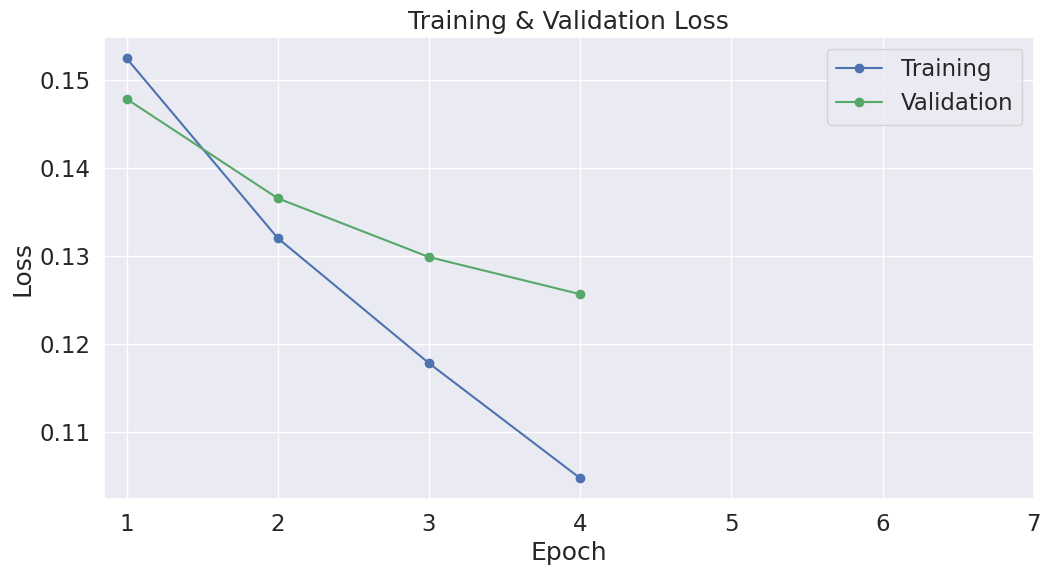

In [81]:
import seaborn as sns
import numpy as np

# plot results
def plot_results():
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(np.arange(1,epochs+1), avg_train_losses, 'b-o', label="Training")
    plt.plot(np.arange(1,epochs+1), avg_val_losses, 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+4)))

    return plt.show()


plot_results()

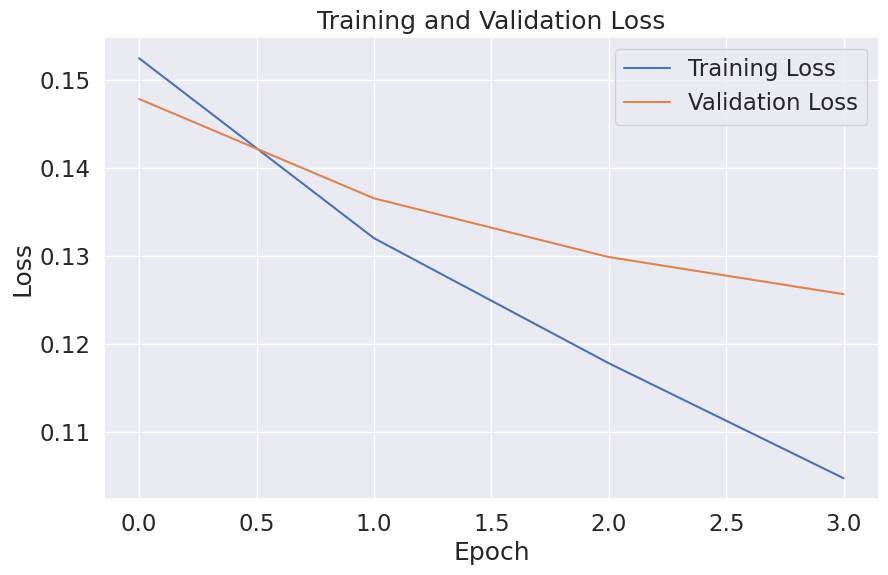

In [82]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(avg_train_losses, label='Training Loss')
plt.plot(avg_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [119]:
# Dataset and dataloader
file_path = "/content/sample_data/data_test_preprocessed.csv"
max_length = 1104 # max input length
batch_size = 32

test_dataset = HateSpeechDataset(file_path, tokenizer, max_length)

test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=my_collate_fn, shuffle=True)

In [120]:
# Test loop
model.load_state_dict(torch.load("/content/bert_model.pt"))
model.eval()
test_losses = []
test_labels = []
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['binary_labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.squeeze(), labels)
        test_losses.append(loss.item())

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(torch.sigmoid(outputs.logits).cpu().numpy())

# Print average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss: {avg_test_loss}')

# Convert predictions to binary values (0 or 1) based on a threshold
threshold = 0.5
binary_predictions = [1 if pred > threshold else 0 for pred in test_predictions]

# Evaluate the performance using metrics like accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, binary_predictions)
precision = precision_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

KeyError: 'binary_labels'